### Loading data

In [3]:
import os
import pandas as pd
import numpy as np

def load_data_from_files(data_dir):
    all_data = []
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            # Extract metadata from filename
            collection_id, step_info, _ = filename.split('_', 2)
            step_number = ''.join(filter(str.isdigit, step_info))
            foot = 'R' if 'R' in step_info else 'L'
            filepath = os.path.join(data_dir, filename)

            df = pd.read_csv(filepath) 

            df['collection_id'] = collection_id + '_' + str(step_number) + '_' + foot  
            df['filename'] = filename  # Keep track of the file
            df['time'] = pd.to_datetime(df['time'])  # Ensure 'time' column is in datetime format
            df['elapsed_time'] = (df['time'] - df['time'].min()).dt.total_seconds()
            df['gyroscope_magnitude'] = np.sqrt(df['gyroscope_x']**2 + df['gyroscope_y']**2 + df['gyroscope_z']**2)
            df['accelerometer_magnitude'] = np.sqrt(df['accelerometer_x']**2 + df['accelerometer_y']**2 + df['accelerometer_z']**2)
            cols = ['collection_id', 'elapsed_time', 'gyroscope_x', 'gyroscope_y', 
                    'gyroscope_z', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'phase', 'gyroscope_magnitude', 'accelerometer_magnitude'] # , 'foot', 'filename']
            df = df[cols] 
            # df = df[df['phase'] != 0]
            all_data.append(df) 
    return pd.concat(all_data, ignore_index=True)

data_dir = '../csv_output_with_phases'  # Replace with your directory
data = load_data_from_files(data_dir) 

### Choose the lag size
AFC plot 
- The ACF plot shows the non-stationarity of the data, thus we might need to use time series data techniques such as lagged features or windowing.  
- In ACF, the blue region shows the 95% confidence interval of the correlation, thus the points that are outside of the blue region are statistically significant. The cut-off point is where the ACF curve crosses the blue line, and the lag at which the ACF curve crosses the blue line is the optimal lag; choose the lag size between 15~20. 

- It can also be seen through the magnitude plot that the phases have patterns as time elapses. 


ACF Cutoff Lag: 20
ACF Cutoff Lag: 19
ACF Cutoff Lag: 18


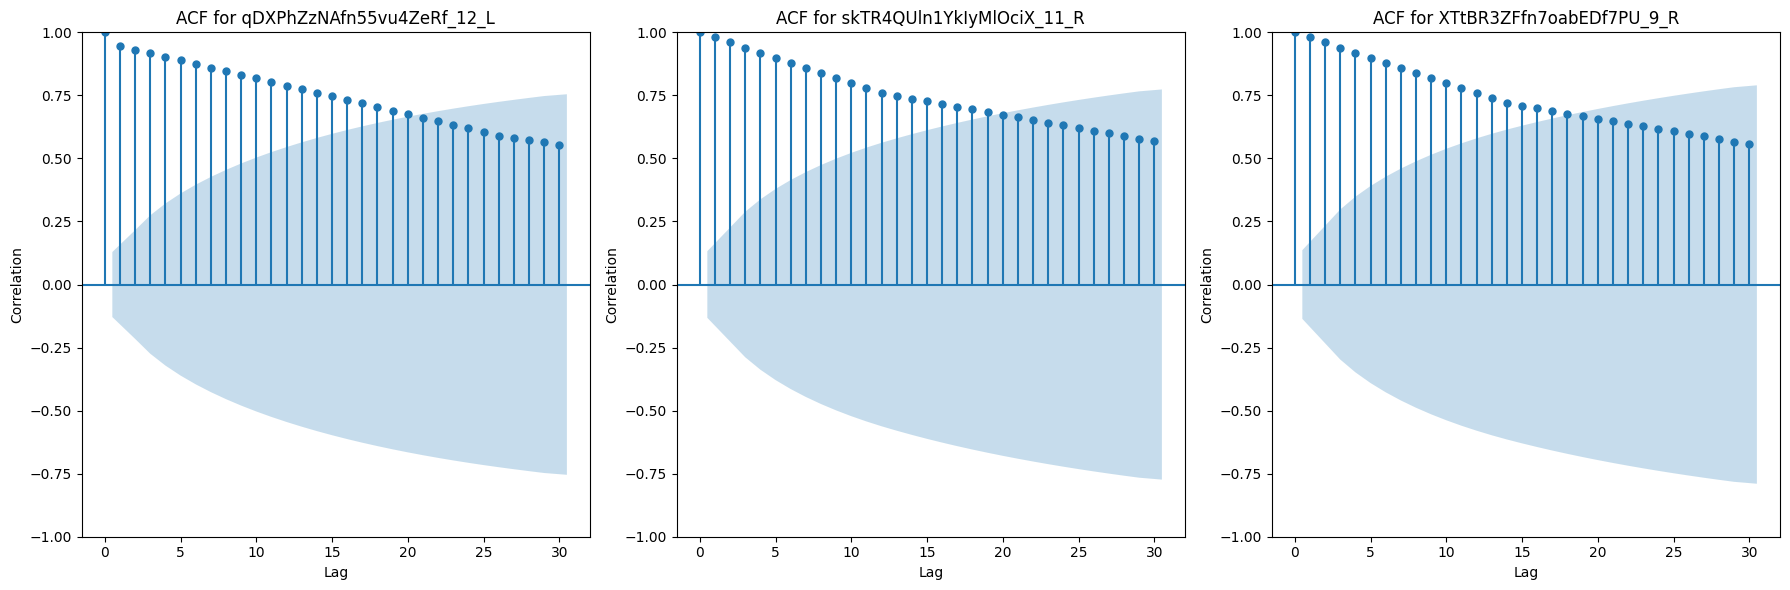

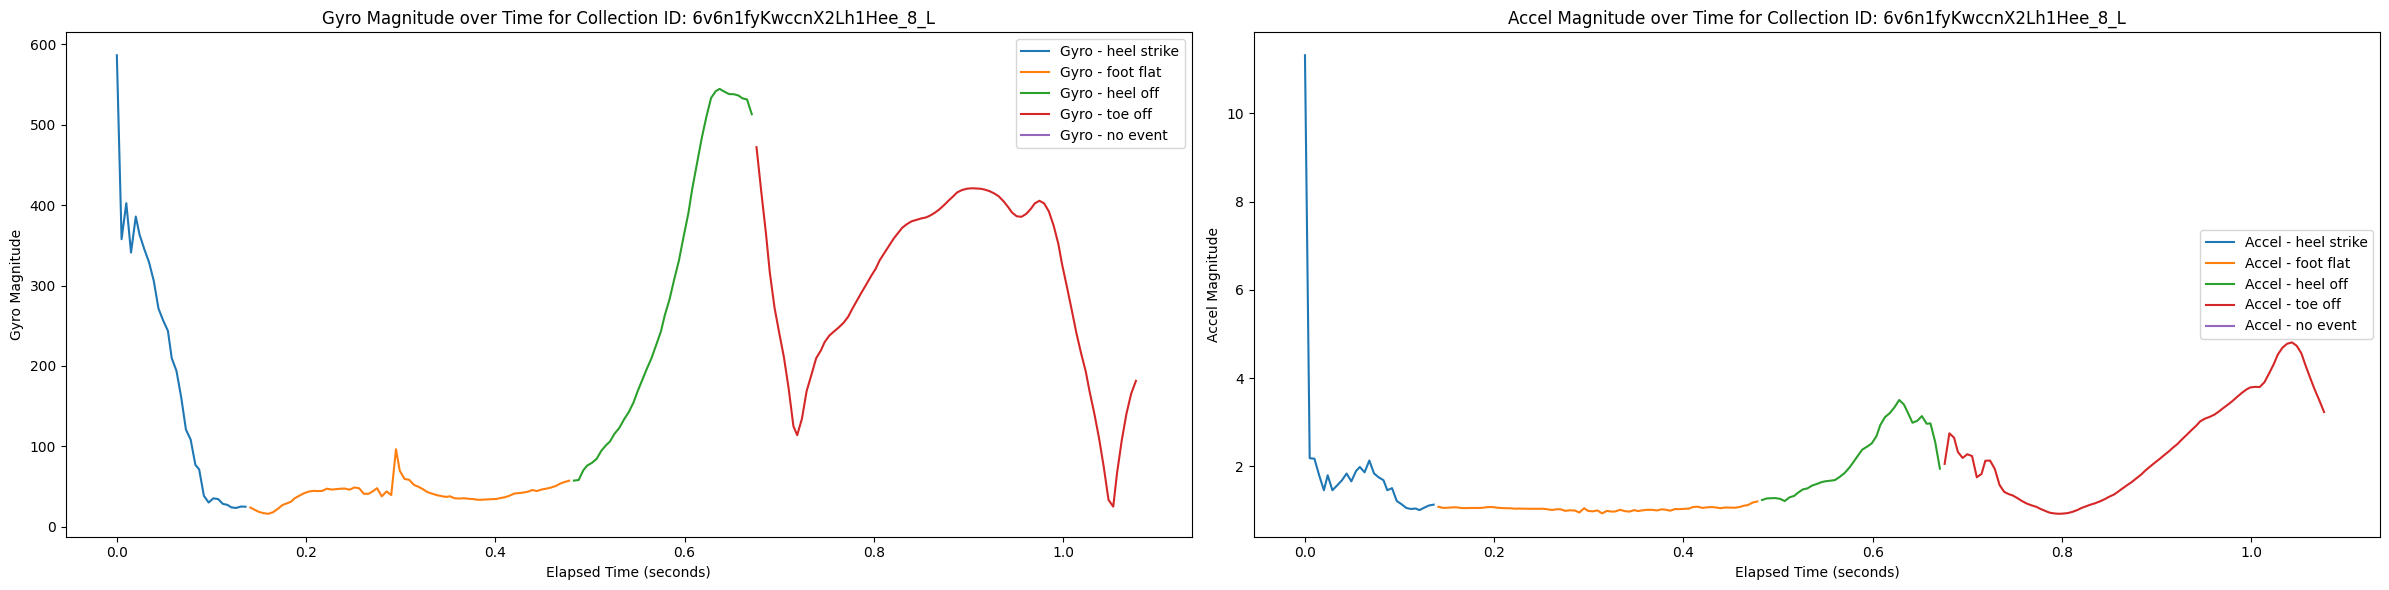

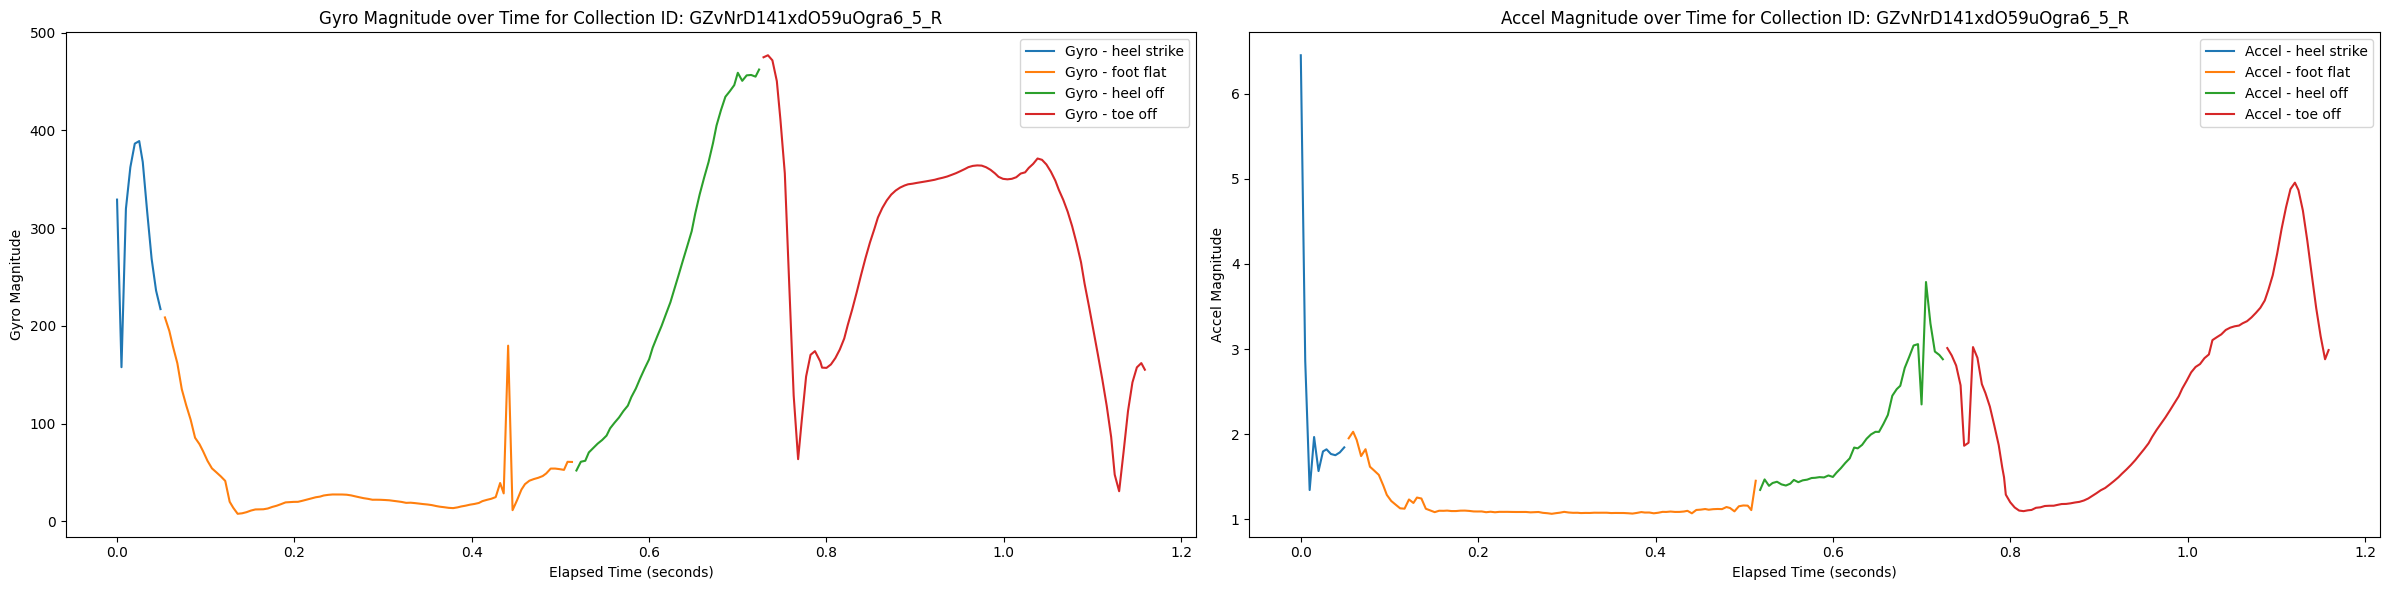

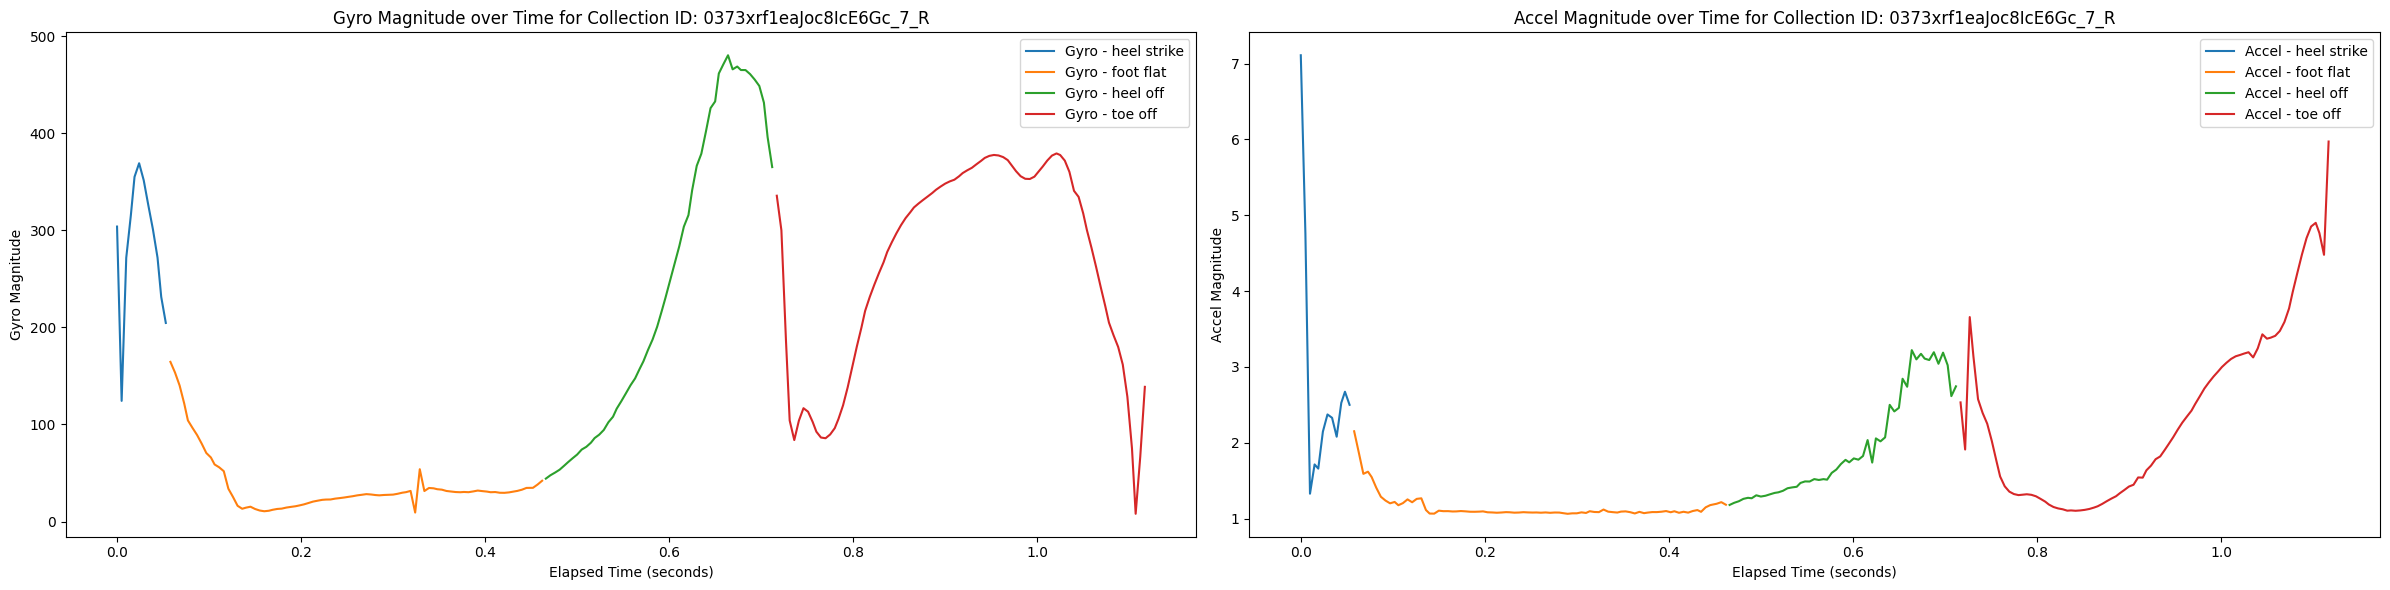

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, acf

def get_three_random_data(data):
    first_three_collection_ids = np.random.choice(data['collection_id'].unique(), 3, replace=False)
    first_three_collection_data = data[data['collection_id'].isin(first_three_collection_ids)].dropna()
    return first_three_collection_data, first_three_collection_ids

def ACF_three_random_data(data, lag=50):
    first_three_collection_data, first_three_collection_ids = get_three_random_data(data)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, collection_id in enumerate(first_three_collection_ids):
        first_target = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]['phase']
        plot_acf(first_target, lags=lag, ax=axes[i], title=f"ACF for {collection_id}")
        axes[i].set_xlabel("Lag")
        axes[i].set_ylabel("Correlation")

        acf_values, confint = acf(first_target, alpha=0.05, nlags=lag)
        lower_bound = confint[1:, 0] - acf_values[1:]
        upper_bound = confint[1:, 1] - acf_values[1:]
        cutoff_lag = np.where((acf_values[1:] < lower_bound) | (acf_values[1:] > upper_bound))[0]
        if len(cutoff_lag) > 0:
            cutoff_lag = cutoff_lag[-1] + 1  # Adjust index to match lag
        else:
            cutoff_lag = 0  # Default value if no significant lag

        print(f"ACF Cutoff Lag: {cutoff_lag}")

    plt.tight_layout()
    plt.show()

def viz_magnitude_three_random_data(data):

    first_three_collection_data, first_three_collection_ids = get_three_random_data(data) 

    # Define phase labels
    phase_labels = {
        0: 'no event',
        1: 'heel strike',
        2: 'foot flat',
        3: 'heel off',
        4: 'toe off'
    }

    # Iterate over each collection_id
    collection_ids = first_three_collection_data['collection_id'].unique()

    for collection_id in collection_ids:
        collection_data = first_three_collection_data[first_three_collection_data['collection_id'] == collection_id]
        
        # Create subplots for gyro_magnitude and accel_magnitude
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
        
        # Plot gyro_magnitude over time for each collection_id with different colors for each phase
        phases = collection_data['phase'].unique()
        for phase in phases:
            phase_data = collection_data[collection_data['phase'] == phase]
            ax1.plot(phase_data['elapsed_time'], phase_data['gyroscope_magnitude'], label=f'Gyro - {phase_labels[phase]}')

        ax1.set_xlabel('Elapsed Time (seconds)')
        ax1.set_ylabel('Gyro Magnitude')
        ax1.set_title(f'Gyro Magnitude over Time for Collection ID: {collection_id}')
        ax1.legend()

        # Plot accel_magnitude over time for each collection_id with different colors for each phase
        for phase in phases:
            phase_data = collection_data[collection_data['phase'] == phase]
            ax2.plot(phase_data['elapsed_time'], phase_data['accelerometer_magnitude'], label=f'Accel - {phase_labels[phase]}')

        ax2.set_xlabel('Elapsed Time (seconds)')
        ax2.set_ylabel('Accel Magnitude')
        ax2.set_title(f'Accel Magnitude over Time for Collection ID: {collection_id}')
        ax2.legend()

        plt.tight_layout()
        plt.show()

ACF_three_random_data(data, lag = 30)
viz_magnitude_three_random_data(data)

In [5]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

def preprocess_data(data):
    # Define features and target
    features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
                'accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_magnitude', 'accelerometer_magnitude']
    target = 'phase'

    # Drop rows with missing values
    data = data.dropna(subset=features + [target])

    # Drop rows with no event 
    data = data[data[target] != 0] 

    # Subtract the phase by 1 : XGboost takes a value from 0 ~ (num_class-1)
    data[target] = data[target] - 1 

    # Normalize features
    scaler = MinMaxScaler()
    data.loc[:, features] = scaler.fit_transform(data[features])

    # Encode target labels
    label_encoder = LabelEncoder()
    data.loc[:, target] = label_encoder.fit_transform(data[target])

    return data, label_encoder

scaled_data, label_encoder = preprocess_data(data)

### Feature Engineering : lagged features 

In [10]:
import pandas as pd
import numpy as np

class Lagged_DataSet:
    def __init__(self, data, features, target, window_size=50):
        self.data = data
        self.features = features
        self.target = target
        self.window_size = window_size

        self.X = []
        self.y = []
        self.collection_ids = []

        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + ['phase', 'collection_id']]
            collection_length = len(collection_data)

            if collection_length > self.window_size:
                # Vectorized lagged features
                lagged_data = [collection_data[self.features].shift(i) for i in range(1, self.window_size)]
                lagged_data = pd.concat(lagged_data, axis=1)
                lagged_columns = [
                    f"{feature}_lag{lag}" for lag in range(1, self.window_size) for feature in self.features
                ]
                lagged_data.columns = lagged_columns

                collection_data = pd.concat([collection_data, lagged_data], axis=1)

            collection_data.dropna(inplace=True)
            self.X.append(collection_data.drop(columns=['phase', 'collection_id', self.target]).values)
            self.y.append(collection_data[self.target].values)
            self.collection_ids.append(np.full(len(collection_data), collection_id))

        # Flatten lists
        self.X = np.vstack(self.X)
        self.y = np.hstack(self.y)
        self.collection_ids = np.hstack(self.collection_ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

dataset_x = Lagged_DataSet(scaled_data, features, target, sequence_length) 


In [9]:
class Lagged_DataSet():
    def __init__(self, data, features, target, window_size=50): 
        self.data = data 
        self.features = features 
        self.len_features = len(self.features) 
        self.target = target 
        self.window_size = window_size

        self.collection_id = 0

        self.X = pd.DataFrame()
        self.y = pd.DataFrame()
        self.collection_ids = pd.DataFrame()

        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + ['phase'] + ['collection_id']] 
            # collection_data = collection_data[self.features + ['phase']] 
            collection_length = len(collection_data)
            if collection_length > self.window_size: 
                lagged_features = {}
                for j in range(self.len_features):
                    for i in range(1, self.window_size):
                        lagged_features[f'{self.features[j]}_lag{i}'] = collection_data[self.features[j]].shift(i)
                lagged_df = pd.DataFrame(lagged_features)
                collection_data = pd.concat([collection_data, lagged_df], axis=1)

            collection_data.dropna(inplace=True) 
            collection_data['collection_id'] = self.collection_id

            collection_data = collection_data.drop(columns=self.features)
            collection_data = collection_data.dropna(axis=1, how='any')
            
            # self.X = pd.concat([self.X, collection_data.drop(columns=[self.target])], ignore_index=True)
            self.X = pd.concat([self.X, collection_data.drop(columns=['phase', 'collection_id'])], ignore_index=True)
            self.y = pd.concat([self.y, collection_data[[self.target]]], ignore_index=True)
            self.collection_ids = pd.concat([self.collection_ids, collection_data[['collection_id']]], ignore_index=True) 

            self.collection_id += 1  
        
        self.X_df = self.X.copy()
        self.y_df = self.y.copy()
        self.collection_ids_df = self.collection_ids.copy()
        
        self.X = self.X_df.values
        self.y = self.y_df.values 
        self.collection_ids = self.collection_ids_df.values 

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx] 
    

features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

dataset = Lagged_DataSet(scaled_data, features, target, sequence_length)  

In [38]:
dataset.collection_ids_df['collection_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [25]:
np.unique(dataset.y_df)

array([0, 1, 2, 3])

groupKFold  
- https://www.geeksforgeeks.org/how-to-generate-a-train-test-split-based-on-a-group-id/#importance-of-groupbased-splitting 
- [Medium](https://medium.com/@danielflor/using-xgboost-with-gpu-in-google-collab-4961999555f4#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6ImRkMTI1ZDVmNDYyZmJjNjAxNGFlZGFiODFkZGYzYmNlZGFiNzA4NDciLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMDMwMDUwNjU5MDc4MTc0MzA5NzUiLCJlbWFpbCI6IndvZHVxMTMyQGdtYWlsLmNvbSIsImVtYWlsX3ZlcmlmaWVkIjp0cnVlLCJuYmYiOjE3Mzc0MzA4MjYsIm5hbWUiOiJKYWV5ZW9wIENodW5nIiwicGljdHVyZSI6Imh0dHBzOi8vbGgzLmdvb2dsZXVzZXJjb250ZW50LmNvbS9hL0FDZzhvY0xKa0Z3UmdpVFQ4VXNVajh4dldmbzllanRpYnp0bmVDNWlOUjYtbXhpN0tNT19sZ3AtPXM5Ni1jIiwiZ2l2ZW5fbmFtZSI6IkphZXllb3AiLCJmYW1pbHlfbmFtZSI6IkNodW5nIiwiaWF0IjoxNzM3NDMxMTI2LCJleHAiOjE3Mzc0MzQ3MjYsImp0aSI6ImJkMDNiYWY2OTRjMjhjYWZmZTM0NWU0ZDEyODdkMDZkNDJlMTAzNDQifQ.GjNHzYHFKdKk3jzyvgmtJdXEgIyh1ayNLem4DQWxIjw_btaeYgUbUSJnnX74ookOwR02wKGmAxoX2OXGqHSzoLidMrH6yJlyF3yq45e5fGPRmgDrIJ-DQD4JtCkmZpdWrwvEXoeyn1L6zCJkcDVdFBvDyAP9Sg8XXoqZc8Us8C8tgC6bLJlRBwdq6ONjYbfkPJg53AGHWUdo9iGhPQ9Ulu0OMHnQ4xwPyYxpoZHuJEUC4kNAPYONO53NrDvyYlP92bolTeAU6CMorZff2fJmzzzoOLzh01MW6u6R6gsCBupGFLibA8KmWUPmt7m-Crqw2zxRFydXMzjk-MdAQmWU2w)
  
- groupkfold vs group shuffle split  
    - https://medium.com/geekculture/cross-validation-techniques-33d389897878  
    - https://www.kaggle.com/code/nicolasgonzalezmunoz/  cross-validation-dataset-split-strategies#Stratified-Group-K-Fold-
- stratifiedGroupKFold(https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html)
- repeated group k-fold(https://datascience.stackexchange.com/questions/63901/cross-validation-repeated-k-fold-group-k-fold)
- Learning curve ( https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html )

Unbalanced data for XGBoost : https://stackoverflow.com/questions/54145714/grid-search-and-xgbclassifier-using-class-weights 

XGBoost eval_result : https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/

XGBoost Cuda : https://stackoverflow.com/questions/77454895/xgboost-warning-running-on-cuda-while-input-data-is-on-cpu  

XGBoost Parameters : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/     

https://xgboost.readthedocs.io/en/stable/parameter.html

GridSearch Plot : https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv 

'super' object has no attribute '__sklearn_tags__' : https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags

XGBoost imbalanced class handling ( sample weight ): https://xgboosting.com/xgboost-scale_pos_weight-vs-sample_weight-for-imbalanced-classification/

train test group split : https://stackoverflow.com/questions/61337373/split-on-train-and-test-separating-by-group 

XGBoost evals result : https://xgboosting.com/xgboost-evals_result-method/#:~:text=The%20evals_result()%20method%20in,performance%20on%20a%20validation%20set   
https://github.com/dmlc/xgboost/issues/8894

grid search ( sample weight 참고 ) : https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html 

결과 모델 플롯 : https://stackoverflow.com/questions/58036921/plot-training-and-validation-loss-curves

Grid Search and Early Stopping Using Cross Validation with XGBoost in SciKit-Learn : 
    https://stackoverflow.com/questions/43866284/grid-search-and-early-stopping-using-cross-validation-with-xgboost-in-scikit-lea   
    https://xgboosting.com/xgboost-early-stopping-with-grid-search/   
    https://gist.github.com/sandys/d0acf13976bae81df253d0a09436cb2b 

    -> Manual implementation ! 
    -> See also : https://xgboosting.com/xgboost-early-stopping-with-random-search/


Grid Search 이후 이 플롯 추가 : https://stackoverflow.com/questions/62363657/how-can-i-plot-validation-curves-using-the-results-from-gridsearchcv

Most Important Parameters to tune : https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/ 

XGBoost default parameters : https://xgboosting.com/xgboost-default-parameters/

XGBoost 장점 : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [68]:
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold, GridSearchCV, train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import matplotlib.pyplot as plt 

def train_XGBoost(dataset):

    groups = dataset.collection_ids_df['collection_id']
    gkf = GroupKFold(n_splits=5)
    xgb_clf = XGBClassifier()

    train_loss_list = []
    test_loss_list = []

    for i, (train_index, test_index) in enumerate(gkf.split(dataset.X, dataset.y, groups)):
        print(f"Fold {i+1}:")
        X_train, x_test = dataset.X[train_index], dataset.X[test_index]
        Y_train, y_test = dataset.y[train_index], dataset.y[test_index]
        eval_set =[(X_train, Y_train), (x_test, y_test)]
        xgb_clf.fit(X_train, Y_train, eval_set=eval_set, verbose=False)

        accuracy = accuracy_score(y_test, xgb_clf.predict(x_test))
        llos = log_loss(y_test, xgb_clf.predict_proba(x_test))
        print(f"Accuracy: {accuracy:.2f}, Log Loss: {llos:.2f}") 

        fold_result = xgb_clf.evals_result() 
        print(f'fold_{i+1}_result')
        print('train_loss : ', np.mean(fold_result['validation_0']['mlogloss']))
        print('test_loss : ', np.mean(fold_result['validation_1']['mlogloss']))
    
        plt.plot(fold_result['validation_0']['mlogloss'], label='train')
        plt.plot(fold_result['validation_1']['mlogloss'], label='test')
        plt.legend()
        plt.show()

        train_loss_list.append(fold_result['validation_0']['mlogloss'])
        test_loss_list.append(fold_result['validation_1']['mlogloss'])

    print(f"Average Accuracy: {np.mean(train_loss_list):.2f}, Average Log Loss: {np.mean(test_loss_list):.2f}")


train_XGBoost(dataset)

Fold 1:
[0]	validation_0-mlogloss:0.95005	validation_1-mlogloss:0.94712
[1]	validation_0-mlogloss:0.71448	validation_1-mlogloss:0.70984
[2]	validation_0-mlogloss:0.56058	validation_1-mlogloss:0.55900
[3]	validation_0-mlogloss:0.45500	validation_1-mlogloss:0.45496
[4]	validation_0-mlogloss:0.37840	validation_1-mlogloss:0.38039
[5]	validation_0-mlogloss:0.32082	validation_1-mlogloss:0.32690
[6]	validation_0-mlogloss:0.27832	validation_1-mlogloss:0.28788
[7]	validation_0-mlogloss:0.24661	validation_1-mlogloss:0.25875
[8]	validation_0-mlogloss:0.22071	validation_1-mlogloss:0.23870
[9]	validation_0-mlogloss:0.20097	validation_1-mlogloss:0.22146
[10]	validation_0-mlogloss:0.18414	validation_1-mlogloss:0.21068
[11]	validation_0-mlogloss:0.17049	validation_1-mlogloss:0.20015
[12]	validation_0-mlogloss:0.16027	validation_1-mlogloss:0.19251
[13]	validation_0-mlogloss:0.15284	validation_1-mlogloss:0.18683
[14]	validation_0-mlogloss:0.14633	validation_1-mlogloss:0.18285
[15]	validation_0-mlogloss:

KeyboardInterrupt: 

In [ ]:
def plot_learning_curve(train_accuracy_list, val_accuracy_list, train_mse_list, val_mse_list, n_iter):
    from scipy.interpolate import make_interp_spline
    import numpy as np

    plt.figure(figsize=(12, 5))

    # Create smooth curves
    x = np.arange(1, n_iter + 1)
    x_smooth = np.linspace(x.min(), x.max(), 300)
    
    train_accuracy_smooth = make_interp_spline(x, train_accuracy_list)(x_smooth)
    val_accuracy_smooth = make_interp_spline(x, val_accuracy_list)(x_smooth)

    plt.plot(x_smooth, train_accuracy_smooth, label='Training Accuracy')
    plt.plot(x_smooth, val_accuracy_smooth, label='Validation Accuracy')
    
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_learning_curve(train_accuracy_list, val_accuracy_list, train_mse_list, val_mse_list, inter_num)

In [43]:
import xgboost
print(f"xgboost version: {xgboost.__version__}")


xgboost version: 2.1.3


In [44]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")


scikit-learn version: 1.5.2


In [ ]:
X = scaled_data[features + ['collection_id']].values 
y = scaled_data[target].values 


In [ ]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")


In [2]:
import pandas as pd
import numpy as np

class Lagged_DataSet:
    def __init__(self, data, features, target, window_size=50):
        self.data = data
        self.features = features
        self.target = target
        self.window_size = window_size

        self.X = []
        self.y = []
        self.collection_ids = []

        for collection_id in self.data['collection_id'].unique():
            collection_data = self.data[self.data['collection_id'] == collection_id].sort_values(by='elapsed_time')
            collection_data = collection_data[self.features + ['phase', 'collection_id']]
            collection_length = len(collection_data)

            if collection_length > self.window_size:
                # Vectorized lagged features
                lagged_data = [collection_data[self.features].shift(i) for i in range(1, self.window_size)]
                lagged_data = pd.concat(lagged_data, axis=1)
                lagged_columns = [
                    f"{feature}_lag{lag}" for lag in range(1, self.window_size) for feature in self.features
                ]
                lagged_data.columns = lagged_columns

                collection_data = pd.concat([collection_data, lagged_data], axis=1)

            collection_data.dropna(inplace=True)
            self.X.append(collection_data.drop(columns=['phase', 'collection_id', self.target]).values)
            self.y.append(collection_data[self.target].values)
            self.collection_ids.append(np.full(len(collection_data), collection_id))

        # Flatten lists
        self.X = np.vstack(self.X)
        self.y = np.hstack(self.y)
        self.collection_ids = np.hstack(self.collection_ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
features = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z',
            'accelerometer_x', 'accelerometer_y', 'accelerometer_z']
target = 'phase'
sequence_length = 15  # hyperparameter to be tuned; 15~20 is optimal

dataset = Lagged_DataSet(scaled_data, features, target, sequence_length) 


NameError: name 'scaled_data' is not defined